## Учим модель отличать фейковые вакансии от настоящих

Бейзлайн

### Затаскиваем основные библиотеки

In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip install --upgrade scikit-learn

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:
from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier #пока не нужна, т.к. в бейзлайн она не пойдет
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [6]:
#Главный набор данных
data = pd.read_csv('fake_job_postings.csv')

In [7]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Смотрим, что за данные, какая их наполняемость..., визуализируем

<AxesSubplot: >

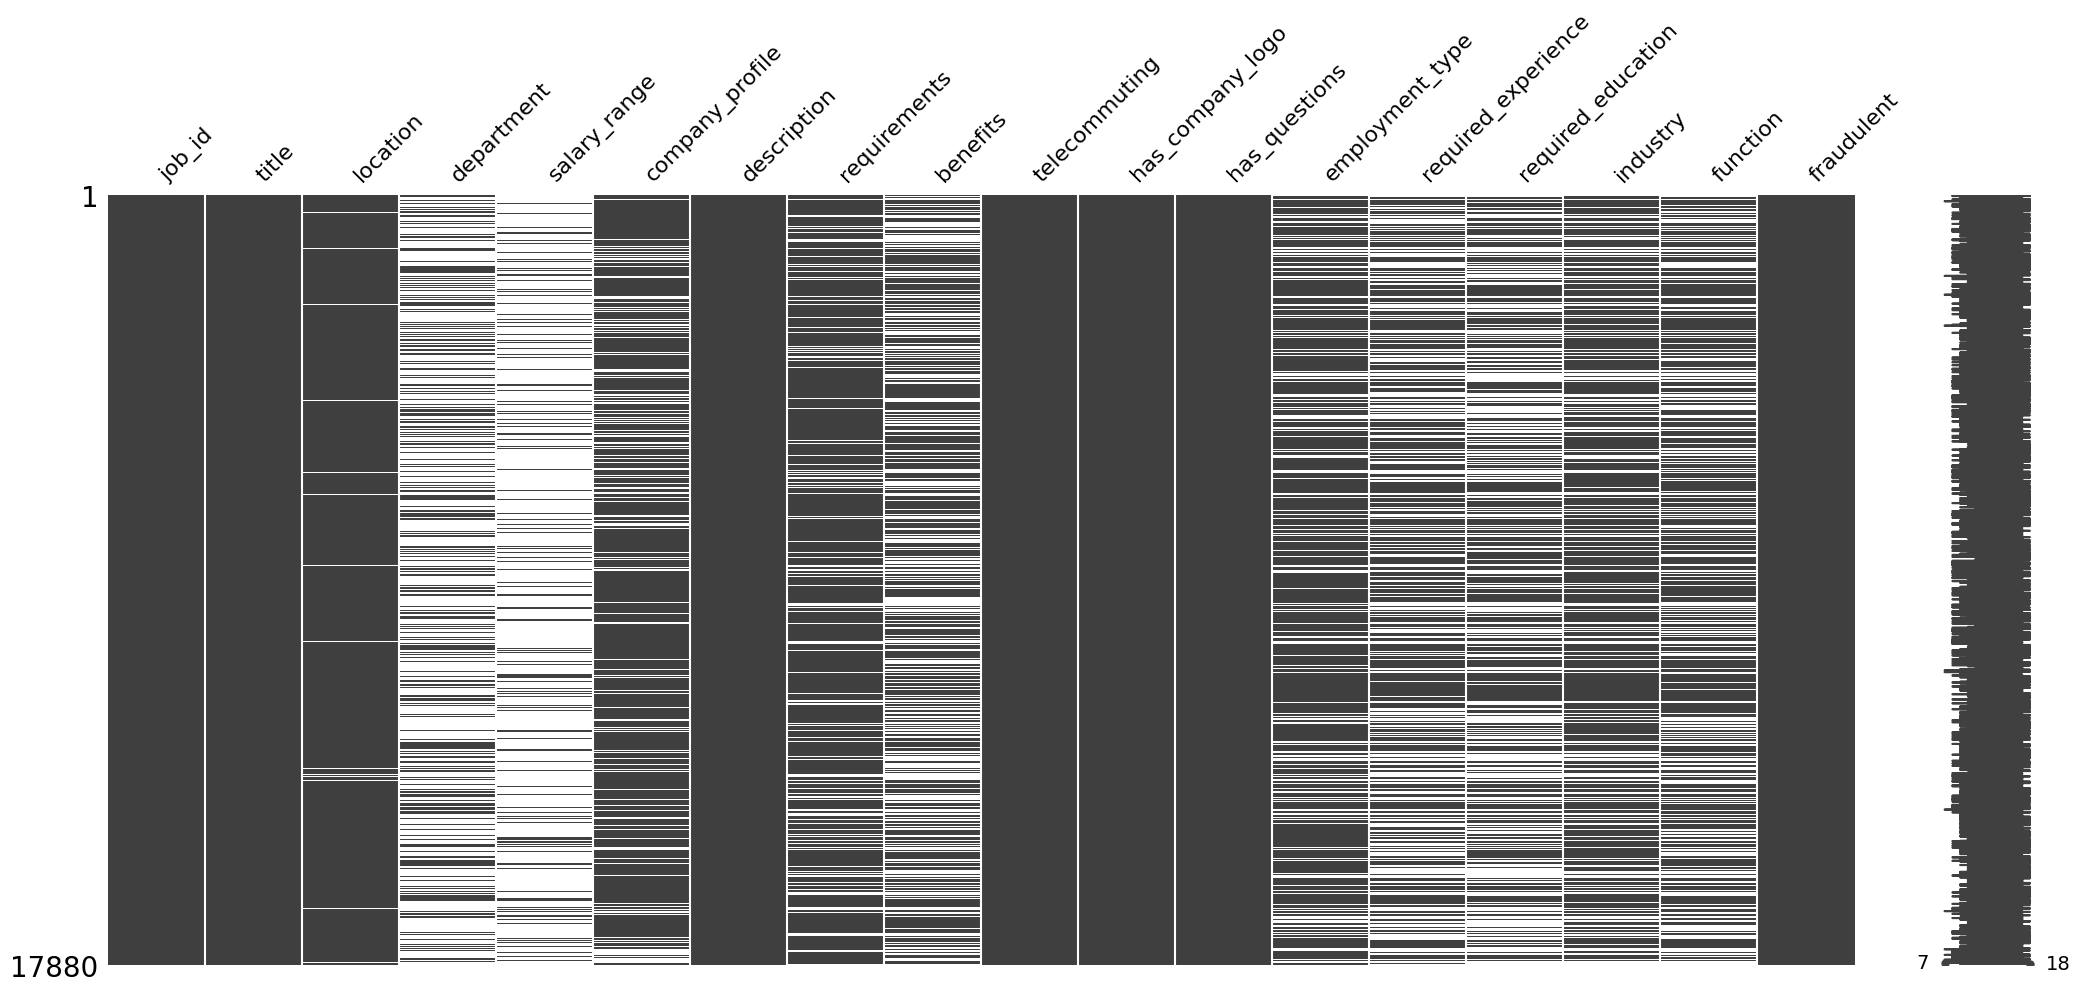

In [8]:
missingno.matrix(data)

In [9]:
print(data.columns)
data.describe()

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\dukha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,fraudulent,title
0,0,17014
1,1,866


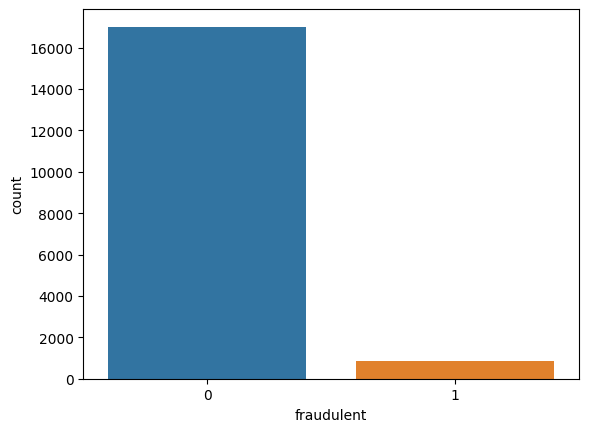

In [10]:
# Выводим распределение объявлений фейковых и реальных вакансий.
sns.countplot(data.fraudulent)
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

In [11]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]
#Удаление нетекстовых колонок
data.fillna(' ', inplace=True)
#забивание пустых ячеек пробелом, чтобы не было пустот

In [12]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [13]:
#переопределение функции, которая разбивает некоторое строковое значение с разделителем "Запятая" через объект "location", 
#имеющим метод split
def split(location):
    l = location.split(',')
    return l[0]
#В data создается колонка, в которую помещается результат переопределенной функции через специальный метод apply.
data['country'] = data.location.apply(split)

In [14]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [15]:
data.describe()

,fraudulent
count,17880.000000
mean,0.048434
std,0.214688
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
# Получаем список первых 11 локаций, которым соответствует самое большое количество надписей. 
# Почему 11 - поскольку может быть не указана локация, что подтвердилось - 346 записей
country = dict(data.country.value_counts()[:11])


In [17]:
country

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 ' ': 346,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127}

In [18]:
del country[' ']
#Убиваем строку с неуказанной локацией


Text(0.5, 0, 'Страны')

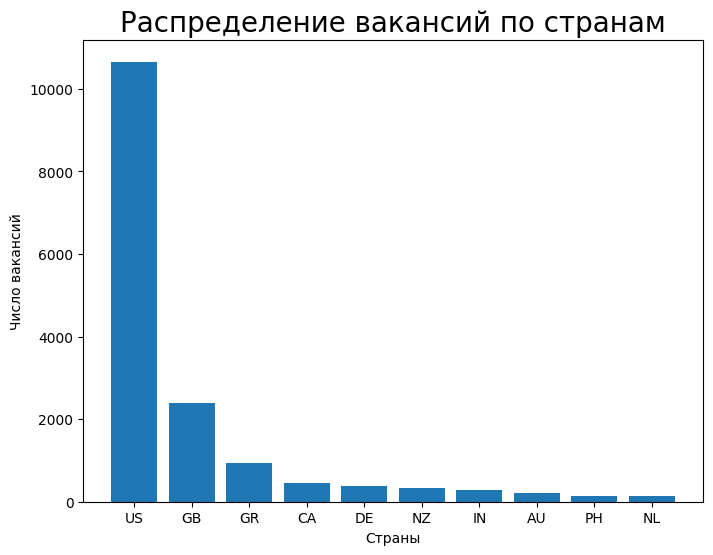

In [19]:
#Выводим распределение стран в форме диаграмм
plt.figure(figsize=(8,6))
plt.title('Распределение вакансий по странам', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('Число вакансий', size=10)
plt.xlabel('Страны', size=10)

Выводим распределение требований к кандидатам к опыту

In [20]:
#Формируем словарь требований к опыту (непустые) и соответствующем числом записей
#Индекс - наименование требования, значение - число записей, которое формируется методом value_counts()
experience = dict(data.required_experience.value_counts())
del experience[' ']
experience

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

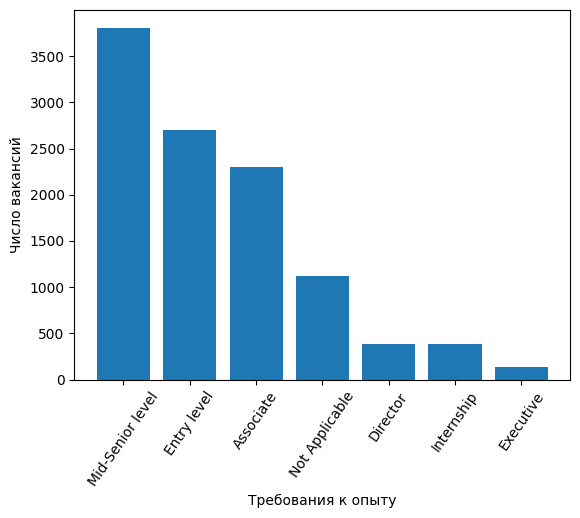

In [21]:
#Выводим распределение в виде столбчатой диаграммы
plt.bar(experience.keys(), experience.values())
plt.xlabel('Требования к опыту', size=10)
plt.ylabel('Число вакансий', size=10)
plt.xticks(rotation=55) #с 35 изменили на 55, чтобы увеличить угол подписей к оси Ох. 
plt.show()

In [22]:
# Выводим число записей, соответствующих наименованием должностей по опубликованным вакансиям
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [23]:
# Склеиваем колонки через пробел и удалем исходные
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

In [24]:
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


In [25]:
#Выделим записи фейковых и реальных вакансий
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text
fraudjobs_text

98       IC&E Technician US, , Stocton, CA             ...
144      Forward Cap.     The group has raised a fund f...
173      Technician Instrument & Controls  US Edison In...
180      Sales Executive PK, SD, Karachi   Sales Execut...
215      IC&E Technician Mt Poso US, CA, Bakersfield, C...
                               ...                        
17827    Student Positions Part-Time and Full-Time. US,...
17828    Sales Associate AU, NSW, Sydney   LEARN TO EAR...
17829    Android Developer PL, MZ, Warsaw   inFullMobil...
17830    Payroll Clerk  US, NY, New York   JOB DESCRIPT...
17831    Furniture mover US, IL, Chicago Anthony Warren...
Name: text, Length: 866, dtype: object

Посмомтрим облака слов для фейковых вакансей

In [26]:
# загрузим стоп-слова
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
# сформируем объект с данными для облака слов, максимум слов - 200 (не 3000, как было - многовато)
wc = WordCloud(min_font_size = 5,  max_words = 200 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))

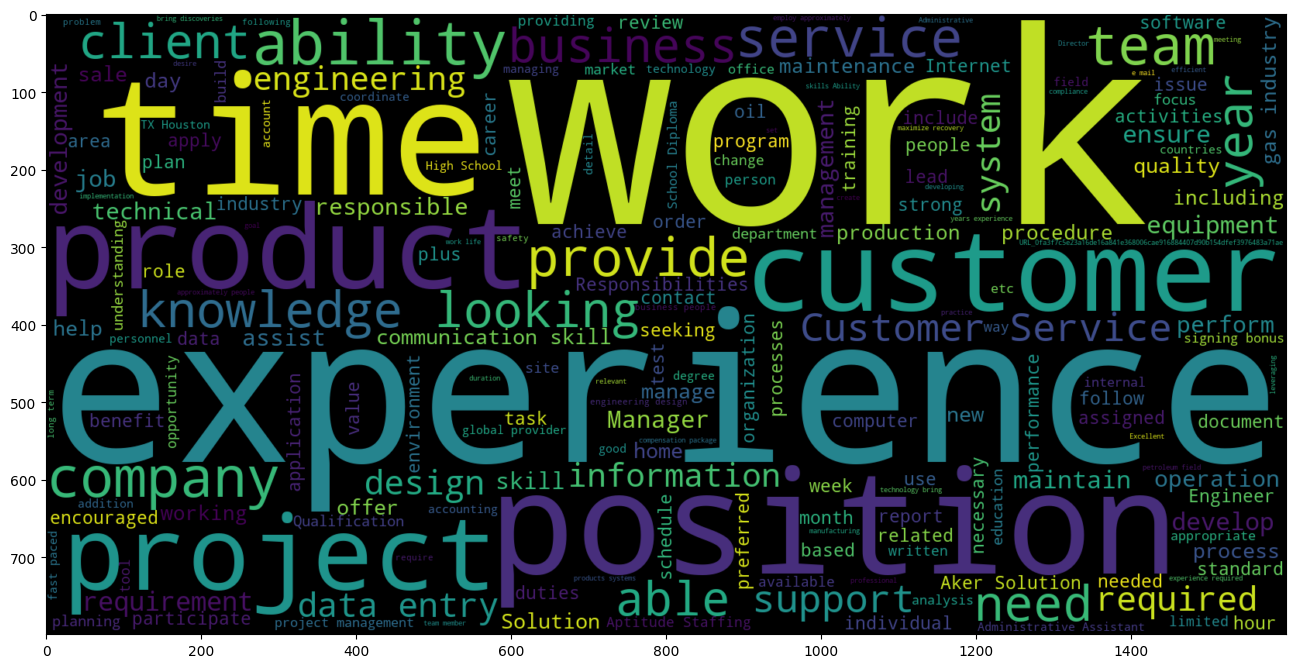

In [27]:
# Визуализируем облако
plt.figure(figsize = (16,14))
plt.imshow(wc,interpolation = 'bilinear')

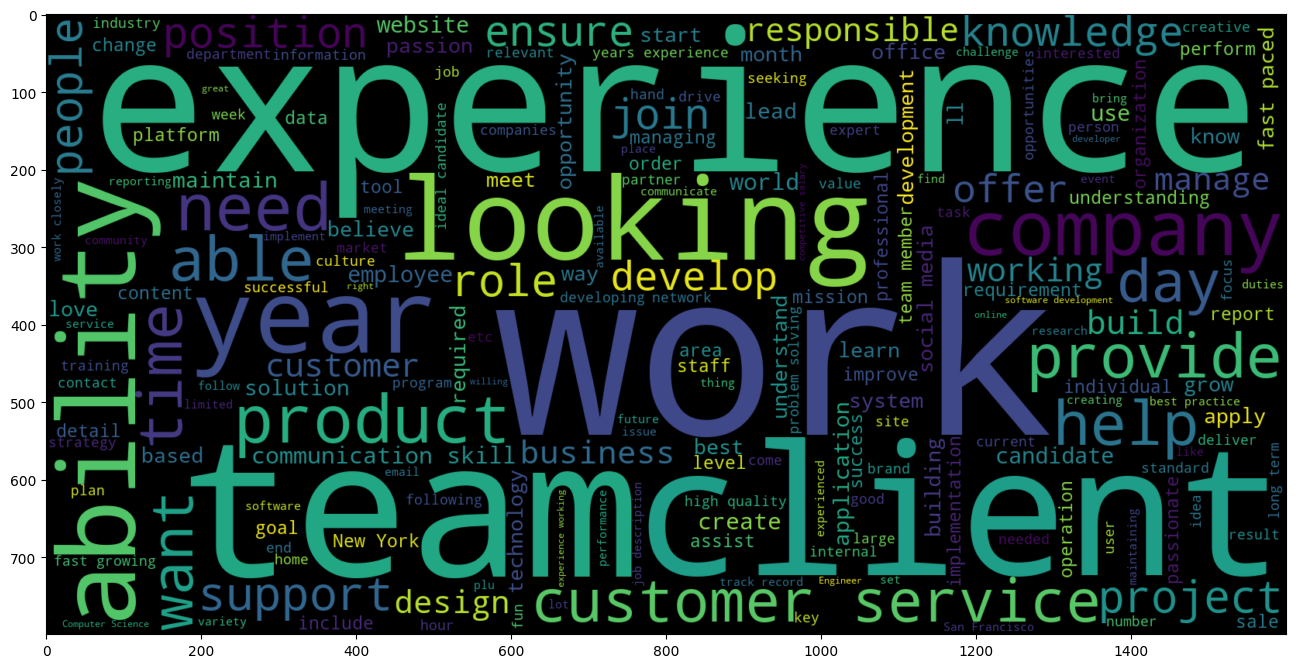

In [28]:
# Делаем тоже самое для реальных вакансий
wc = WordCloud(min_font_size = 5,  max_words = 200 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.figure(figsize = (16,14))
plt.imshow(wc,interpolation = 'bilinear')

In [29]:
#!python -m spacy download en_core_web_sm

In [30]:
#!python -m spacy link en_core_web_sm en

In [31]:
# Создание списка символов пунктуации
punctuations = string.punctuation

# Список стоп-слов
#nlp = spacy.load('en')
#Это не работает с третьей версии spacy, ниже переделанный вариант

nlp = spacy.load('en_core_web_sm') #English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Загрузка токенизатора, теггера, парсера, NER (именованные сущности, например, Майкл Джексон - распознавание), и вектора слов
parser = English()



In [32]:
nlp

In [33]:
parser

In [34]:
# Функция токенизации
def spacy_tokenizer(sentence):
    # Создание объекта токенов для создания документов с лингвистическим аннторированием
    mytokens = nlp(sentence)

    # Лемматизация каждого токина, конвертация токена в нижний регистр
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Удаление стоп-слов
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # возврат списка предобработанных токенов
    return mytokens

In [35]:
# Простенькая функция почистить текст
def clean_text(text):
    # убираем пробелы и переводим декст в нижний регистр
    return text.strip().lower()

In [36]:
# Переопределяем класс TransformerMixin Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Чистим текс (см выше)
        return [clean_text(text) for text in X]
         
        # Обучаем
    def fit(self, X, y=None, **fit_params): #y=None
        return self
        # Получение словаря, заданного на конструкторе класса
    def get_params(self, deep=True):
        return {}



In [37]:
# создание мешка слов
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))

In [38]:
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function spacy_tokenizer at 0x000001E6E7718940>)

In [39]:
# формирование обучающей и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

In [40]:
# Делаем пайплайн на основе мешка слов, класса predictors (преобразование текстов)
    
# Сам пайплайн
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', LogisticRegression())])

In [41]:
%%time
# Учим модель  
pipe.fit(X_train, y_train)



C:\Users\dukha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Wall time: 10min 57s


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000001E6816CCAC0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function spacy_tokenizer at 0x000001E6E7718940>)),
                ('classifier', LogisticRegression())])

In [42]:
%%time
# Инференс обученной модели на тестовой выборек
predicted = pipe.predict(X_test)


Wall time: 4min 24s


In [44]:
predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Accuracy:  0.9835943325876212
Recall:  0.6942446043165468


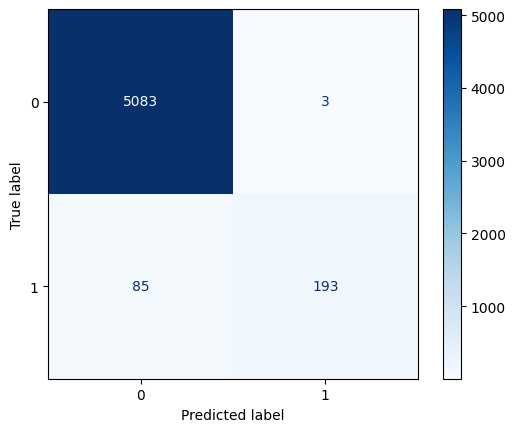

In [43]:
# Вычисление метрик и их печать
print("Accuracy: " , accuracy_score(y_test, predicted))
print("Recall: ", recall_score(y_test, predicted))

# вывод матрицы ошибок
cm = confusion_matrix(y_test, predicted, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()